## Overview of Particle Detection Analysis Notebook

This notebook is designed to analyze particle collision data to detect the presence of hypothetical Z' bosons and estimate their mass using machine learning models.

### Key Steps:

1. **Data Handling:** We start by loading collision data from HDF5 files, which include both potential Z' boson signals (signal) and other background events. The data is preprocessed to ensure it's suitable for analysis, involving normalization and handling of missing values.

2. **Classification:** A neural network classifier is used to sift through events and identify those likely to contain Z' bosons. This step filters out most background noise, focusing on events of interest.

3. **Regression Analysis:** For events classified as containing Z' bosons, we apply a regression model to estimate the mass of these particles. This involves predicting a continuous value (the mass) from the features extracted in the collision data.

4. **Model Evaluation:** The performance of both models is quantitatively assessed using metrics such as accuracy, precision, recall, F1-score for classification, and MSE, RMSE, MAE, R² for regression. Additionally, we compute the statistical significance of our findings to validate the detections.

5. **Visualization:** We use histograms and scatter plots to visually compare the predicted masses against known values and evaluate the quality of our regression model.

### Conclusion:

Through this notebook, we aim to first identify Z' boson events from large datasets and then estimate the mass, providing valuable insights for particle physics research.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import joblib
import time
from fastai.tabular.all import *
from fastai.learner import load_learner
import gc
import warnings
import scipy.stats as stats
import os


#### Configurations

In [3]:
# Define subset size
subset_size = 1

In [4]:
# Set a fixed seed for reproducibility -> This assures consistent results on the training data
fixed_seed = 42
np.random.seed(fixed_seed)

In [5]:
# Ignore specific warnings
warnings.filterwarnings('ignore', message=".*'has_mps'.*")

In [6]:
# Specify the correct path to your file on Kaggle
path = '/kaggle/input/zparticlesearch/mc_110901.ZPrime500/'
path2 = '/kaggle/input/zparticlesearch/Signal_test_only'
path3 = '/kaggle/input/zparticlesearch/allfiles/allfiles'

#### Define functions

In [7]:
# Define the function to extract mass from the filename
def extract_mass_from_filename(filename):
    # Split by '.' and extract the part with 'ZPrime', then remove non-digit characters
    return int(''.join(filter(str.isdigit, filename.split('.')[1])))

def extract_mass_parameter_from_file_name(filename):
    # Regular expression to find numbers followed by '.hdf5'
    match = re.search(r'(\d+)\.hdf5$', filename)
    if match:
        return match.group(1)
    return None

# Loads data and adds weight and new features that uses invariant mass formula to improve the regression model
def load_data(filename, path, label, subset_size, include_mass=True):
    with h5py.File(f"{path}/{filename}", 'r') as file:
        data = pd.DataFrame(file['mini'][:])
        data['label'] = label
        if include_mass:
            data['mass'] = extract_mass_parameter_from_file_name(filename)
        data = data.sample(frac=subset_size, random_state=fixed_seed)
        data['total_weight'] = data['mcWeight']  # Start with mcWeight for each event

        # List all scale factors
        scale_factors = ['scaleFactor_BTAG', 'scaleFactor_ELE', 'scaleFactor_JVFSF',
                         'scaleFactor_MUON', 'scaleFactor_PILEUP', 'scaleFactor_TRIGGER',
                         'scaleFactor_ZVERTEX']

        # Apply each scale factor directly
        for sf in scale_factors:
            data['total_weight'] *= data[sf]

        # Add cosTheta calculation for jets and leptons
        for i in range(1, 7):
            jet_eta_col = f'jet_{i}_eta'
            if jet_eta_col in data.columns:
                data[f'jet_{i}_cosTheta'] = cosTheta_from_eta(data[jet_eta_col])

        for i in range(1, 6):
            lep_eta_col = f'lep_{i}_eta'
            if lep_eta_col in data.columns:
                data[f'lep_{i}_cosTheta'] = cosTheta_from_eta(data[lep_eta_col])

        # Calculate features for invariant mass estimates
        try:
            data['feature_1'] = (data[[f'jet_{i}_E' for i in range(1, 7)]].sum(axis=1))**2 - \
                                (data[[f'jet_{i}_pt' for i in range(1, 7)]] / data[[f'jet_{i}_cosTheta' for i in range(1, 7)]].replace(0, np.nan)).sum(axis=1)**2
            data['feature_2'] = (data[[f'jet_{i}_E' for i in range(1, 5)] + ['lep_1_E']].sum(axis=1))**2 - \
                                (data[[f'jet_{i}_pt' for i in range(1, 5)] + ['lep_1_pt']] / data[[f'jet_{i}_cosTheta' for i in range(1, 5)] + ['lep_1_cosTheta']].replace(0, np.nan)).sum(axis=1)**2
            data['feature_3'] = (data[['jet_1_E', 'jet_2_E', 'lep_1_E', 'lep_2_E']].sum(axis=1))**2 - \
                                (data[['jet_1_pt', 'jet_2_pt', 'lep_1_pt', 'lep_2_pt']] / data[['jet_1_cosTheta', 'jet_2_cosTheta', 'lep_1_cosTheta', 'lep_2_cosTheta']].replace(0, np.nan)).sum(axis=1)**2
        except KeyError as e:
            print(f"Skipping feature calculation: {str(e)}")

        return data


In [8]:
# Function to find the optimal cutoff for maximizing significance with weights
def find_optimal_cutoff(df_signal, df_background, feature='ML_output', weight='total_weight'):
    best_significance, best_cutoff = 0, 0
    for cutoff in np.linspace(df_signal[feature].min(), df_signal[feature].max(), num=100):
        S = df_signal[df_signal[feature] > cutoff][weight].sum()
        B = df_background[df_background[feature] > cutoff][weight].sum()
        significance = S / np.sqrt(B) if B > 0 else 0
        if significance > best_significance:
            best_significance = significance
            best_cutoff = cutoff
    return best_cutoff

In [9]:
def predict_model(learn, df_combined, features):
    # Prepare data loader for the model predictions
    dl = learn.dls.test_dl(df_combined[features], bs=1024)
    
    # Get predictions and add them to the DataFrame
    preds, _ = learn.get_preds(dl=dl)
    df_combined['ML_output'] = preds[:, 1].numpy()
    return preds, df_combined

In [14]:
def cosTheta_from_eta(eta):
    # Calculate the denominator for the arctan calculation
    denominator = np.exp(-eta)
    
    # Handle cases where the denominator approaches zero to avoid division by zero
    cosTheta = np.where(denominator == 0, 0, 2 * np.arctan(denominator))
    
    return cosTheta

In [15]:
def prepare_data(signal_files, background_files, path, subset_size):
    # Initialize lists for holding the dataframes
    df_signal_list = []
    df_background_list = []

    # Load and sample signal data for each Z' particle mass scenario
    for s_file in signal_files:
        df_signal = load_data(s_file, path, 1, subset_size)  # Load a subset (global variable)
        df_signal_list.append(df_signal)  # Collect all signal dataframes

    # Since we aim for the background to be evenly distributed across tests,
    # each portion of the background data should be a signal subset (global variable) divided by 7
    background_subset_frac = subset_size / 7

    # Sample this fraction from each background dataset
    for b_file in background_files:
        df_background = load_data(b_file, path, 0, background_subset_frac)  # Use calculated fraction directly
        df_background_list.append(df_background)  # Collect adjusted background dataframes

    # Combine individual dataframes into two large ones for signal and background
    df_signal_combined = pd.concat(df_signal_list, ignore_index=True)
    df_background_combined = pd.concat(df_background_list, ignore_index=True)

    return df_signal_combined, df_background_combined

In [16]:
# Function to convert significance to sigma level
def significance_to_sigma(significance):
    return stats.norm.ppf(1 - stats.norm.cdf(significance))

# Function to calculate sigma level interpretation based on significance value
def calculate_sigma_level(significance):
    if significance < 1:
        return "Low significance (less than 1σ)"
    elif significance < 2:
        return "Intriguing (about 2σ)"
    elif significance < 3:
        return "Evidence (about 3σ)"
    elif significance < 4:
        return "Strong evidence (about 4σ)"
    elif significance < 5:
        return "Very strong evidence (about 5σ)"
    else:
        return "Discovery (more than 5σ)"

# Evaluate model significance along with performance metrics
def evaluate_model_significance(df_signal_combined, df_background_combined, learn, path, features, subset_size):
    significance_results = {}  # Storing significance results for each Z' mass hypothesis
    performance_results = {}  # Storing performance metrics results for each Z' mass hypothesis
    sigma_results = {}  # Dictionary to store sigma results for each Z' mass hypothesis

    # Loop through each file (each represents a different Z' mass hypothesis)
    for s_file in signal_files:
        mass = extract_mass_from_filename(s_file)
        
        # Prepare the dataset for this specific Z' mass hypothesis
        df_signal = load_data(s_file, path, 1, subset_size)
        df_combined = pd.concat([df_signal, df_background_combined], ignore_index=True).sample(frac=1, random_state=fixed_seed)
        
        # Get model predictions for the combined dataset
        dl = learn.dls.test_dl(df_combined[features], bs=1024)
        preds, _ = learn.get_preds(dl=dl)
        df_combined['ML_output'] = preds[:, 1].numpy()

        # Calculate optimal cutoff for maximizing significance
        optimal_cutoff = find_optimal_cutoff(df_combined[df_combined['label'] == 1], df_combined[df_combined['label'] == 0], 'ML_output', 'total_weight')

        # Apply the optimal cutoff to calculate significance using event weights
        weighted_S = df_combined[(df_combined['ML_output'] > optimal_cutoff) & (df_combined['label'] == 1)]['total_weight'].sum()
        weighted_B = df_combined[(df_combined['ML_output'] > optimal_cutoff) & (df_combined['label'] == 0)]['total_weight'].sum()
        weighted_significance = weighted_S / np.sqrt(weighted_B) if weighted_B > 0 else 0

        # Convert weighted significance to sigma level
        sigma = significance_to_sigma(weighted_significance)

        # Print and store the calculated metrics
        predictions = (df_combined['ML_output'] > optimal_cutoff).astype(int)
        true_labels = df_combined['label'].values
        conf_matrix = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for Z\' Mass {mass} GeV')
        plt.show()

        # Extract confusion matrix elements and calculate performance metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)

        # Store and print performance metrics
        print(f'Accuracy for Z\' Mass {mass} GeV: {accuracy:.4f}')
        print(f'Precision for Z\' Mass {mass} GeV: {precision:.4f}')
        print(f'Recall for Z\' Mass {mass} GeV: {recall:.4f}')
        print(f'F1-Score for Z\' Mass {mass} GeV: {f1:.4f}')
        print(f'Significance (using optimal cutoff {optimal_cutoff}): {weighted_significance:.4f}')
        
        # Interpret significance level in terms of sigma
        sigma_level_interpretation = calculate_sigma_level(weighted_significance)
        print(f'Sigma level interpretation: {sigma_level_interpretation}')

        significance_results[mass] = weighted_significance
        sigma_results[mass] = sigma
        performance_results[mass] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}

    # Plotting the significance vs mass graph
    masses = sorted(significance_results.keys())
    significances = [significance_results[m] for m in masses]
    plt.figure(figsize=(10, 6))
    plt.plot(masses, significances, marker='o', label='Significance')
    plt.xlabel('Z\' Mass (GeV)')
    plt.ylabel('Significance')
    plt.title('Significance vs Z\' Particle Mass')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting all performance metrics vs Z' particle mass in one graph
    plt.figure(figsize=(12, 8))
    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score']:
        metric_values = [performance_results[mass][metric_name] for mass in masses]
        plt.plot(masses, metric_values, marker='o', label=metric_name.capitalize())

    plt.xlabel("Z' Mass (GeV)")
    plt.ylabel("Metric Value")
    plt.title("Performance Metrics vs Z' Particle Mass")
    plt.legend()
    plt.grid(True)
    plt.show()

    return significance_results, sigma_results, performance_results

In [17]:
# Define a function to plot all metrics versus Z' particle mass
def plot_metrics_vs_mass(masses, performance_results):
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Significance']
    plt.figure(figsize=(12, 8))
    
    for metric_name in metric_names:
        metric_values = [performance_results[mass][metric_name.lower()] for mass in masses]
        plt.plot(masses, metric_values, marker='o', label=metric_name)

    plt.xlabel("Z' Mass (GeV)")
    plt.ylabel("Metric Value")
    plt.title("Performance Metrics vs Z' Particle Mass")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define a dictionary to store performance results
performance_results = {}

### Now we must do the data preparation just as we did in part 1 and 2.

In [18]:
# List of background files
background_files = [
    'mc_105986.ZZ.hdf5',
    'mc_105987.WZ.hdf5',
    'mc_110090.stop_tchan_top.hdf5',
    'mc_110091.stop_tchan_antitop.hdf5',
    'mc_110119.stop_schan.hdf5',
    'mc_110140.stop_wtchan.hdf5',
    'mc_117049.ttbar_had.hdf5',
    'mc_117050.ttbar_lep.hdf5',
    'mc_147770.Zee.hdf5',
    'mc_147771.Zmumu.hdf5',
    'mc_147772.Ztautau.hdf5',
    'mc_167740.WenuWithB.hdf5',
    'mc_167743.WmunuWithB.hdf5',
    'mc_167746.WtaunuWithB.hdf5',
    'mc_173041.DYeeM08to15.hdf5',
    'mc_173042.DYeeM15to40.hdf5',
    'mc_173043.DYmumuM08to15.hdf5',
    'mc_173044.DYmumuM15to40.hdf5',
    'mc_173045.DYtautauM08to15.hdf5',
    'mc_173046.DYtautauM15to40.hdf5'
]


# List of signal files
signal_files = [
    'mc_110901.ZPrime500.hdf5',
    'mc_110902.ZPrime750.hdf5',
    'mc_110903.ZPrime1000.hdf5',
    'mc_110905.ZPrime1500.hdf5',
    'mc_110906.ZPrime1750.hdf5',
    'mc_110907.ZPrime2000.hdf5',
    'mc_110909.ZPrime2500.hdf5'
]

# List of NEW UNSEEN signal files
test_only_signal_files = [
    'mc_110904.ZPrime1250.hdf5',
    'mc_110908.ZPrime2250.hdf5'
]

#### Load and prepare the data

In [96]:
# Load or prepare your signal and background data
df_signal_combined, df_background_combined = prepare_data(signal_files, background_files, path, subset_size)

In [97]:
# Print total number of signal and background files
print(f"Total Signal Files: {len(signal_files)}")
print(f"Total Background Files: {len(background_files)}")

# Print total number of signal samples
total_signal_samples = len(df_signal_combined)
print(f"Total Signal Samples: {total_signal_samples}")

# Print total number of background samples
total_background_samples = len(df_background_combined)
print(f"Total Background Samples: {total_background_samples}")

Total Signal Files: 7
Total Background Files: 20
Total Signal Samples: 163308
Total Background Samples: 3206085


In [98]:
# Combine background and signal data into a single DataFrame
df_combined = pd.concat([df_signal_combined, df_background_combined])

# Shuffle the combined DataFrame to ensure random mixing of signal and background events
df_combined = shuffle(df_combined, random_state=fixed_seed)

#### Same feature selection as before

In [31]:
# Define excluded features
excluded_features = [
    'eventWeight', 
    'mcWeight', 
    'channelNumber', 
    'runNumber', 
    'data_type', 
    'label', 
    'eventNumber', 
    'jet_6_SV0', 
    'jet_7_SV0', 
    'jet_8_SV0', 
    'jet_9_SV0', 
    'jet_8_trueflav', 
    'jet_9_trueflav',
    'lep_4_E',                       
    'lep_4_charge',            
    'lep_4_eta',                     
    'lep_4_etcone20',                
    'lep_4_flag',                   
    'lep_4_phi',                     
    'lep_4_pt',                      
    'lep_4_ptcone30',                
    'lep_4_trackd0pvunbiased',       
    'lep_4_tracksigd0pvunbiased',    
    'lep_4_type',                   
    'lep_4_z0',                     
    'lep_5_E',                       
    'lep_5_charge',                  
    'lep_5_eta',                     
    'lep_5_etcone20',             
    'lep_5_flag',                    
    'lep_5_phi',                     
    'lep_5_pt',                      
    'lep_5_ptcone30',             
    'lep_5_trackd0pvunbiased',      
    'lep_5_tracksigd0pvunbiased',   
    'lep_5_type',                    
    'lep_5_z0',                                               
    'lep_trigMatched',      
    'jet_1_trueflav',                
    'jet_1_truthMatched',            
    'jet_2_trueflav',                
    'jet_2_truthMatched',            
    'jet_3_trueflav',                
    'jet_3_truthMatched',            
    'jet_4_trueflav',                
    'jet_4_truthMatched',            
    'jet_5_trueflav',                
    'jet_5_truthMatched',            
    'jet_6_trueflav',                
    'jet_6_truthMatched',            
    'jet_7_trueflav',                
    'jet_7_truthMatched',            
    'jet_8_trueflav',                
    'jet_8_truthMatched',            
    'jet_9_trueflav',                
    'jet_9_truthMatched',            
    'runNumber',                     
    'scaleFactor_BTAG',              
    'scaleFactor_ELE',               
    'scaleFactor_JVFSF',             
    'scaleFactor_MUON',              
    'scaleFactor_PILEUP',            
    'scaleFactor_TRIGGER',           
    'scaleFactor_ZVERTEX',
    # Exclude these because they are only suppposed to be in regression
    'jet_1_cosTheta',
    'jet_2_cosTheta',
    'jet_3_cosTheta',
    'jet_4_cosTheta',
    'jet_5_cosTheta',
    'jet_6_cosTheta',
    'lep_1_cosTheta',
    'lep_2_cosTheta',
    'lep_3_cosTheta',
    'lep_4_cosTheta',
    'lep_5_cosTheta',
    'feature_1',
    'feature_2',
    'feature_3'
]

In [ ]:
# Select features for model training, excluding the ones specified
features = [col for col in df_combined.columns if col not in excluded_features]

#### Load the best model (Neural network with undersampling)

In [100]:
# Load the trained model
learn = load_learner("/kaggle/input/undersampled_model/pytorch/version1.0/8/undersampled_model-10-to-1-not5.pkl")


### Evaluate the model

In [101]:
# Apply the function and assign the result to df_combined
_, df_combined = predict_model(learn, df_combined, features)

# Print the shape of df_combined
print(df_combined.shape)

(3369393, 187)


In [102]:
# Define the function to extract mass from the filename
def extract_mass_from_filename(filename):
    # Split by '.' and extract the part with 'ZPrime', then remove non-digit characters
    return int(''.join(filter(str.isdigit, filename.split('.')[1])))
for filename in background_files + signal_files:
    print(filename)


mc_105986.ZZ.hdf5
mc_105987.WZ.hdf5
mc_110090.stop_tchan_top.hdf5
mc_110091.stop_tchan_antitop.hdf5
mc_110119.stop_schan.hdf5
mc_110140.stop_wtchan.hdf5
mc_117049.ttbar_had.hdf5
mc_117050.ttbar_lep.hdf5
mc_147770.Zee.hdf5
mc_147771.Zmumu.hdf5
mc_147772.Ztautau.hdf5
mc_167740.WenuWithB.hdf5
mc_167743.WmunuWithB.hdf5
mc_167746.WtaunuWithB.hdf5
mc_173041.DYeeM08to15.hdf5
mc_173042.DYeeM15to40.hdf5
mc_173043.DYmumuM08to15.hdf5
mc_173044.DYmumuM15to40.hdf5
mc_173045.DYtautauM08to15.hdf5
mc_173046.DYtautauM15to40.hdf5
mc_110901.ZPrime500.hdf5
mc_110902.ZPrime750.hdf5
mc_110903.ZPrime1000.hdf5
mc_110905.ZPrime1500.hdf5
mc_110906.ZPrime1750.hdf5
mc_110907.ZPrime2000.hdf5
mc_110909.ZPrime2500.hdf5


In [103]:
# Print the first 10 filenames stored in df_combined
print(df_combined[:5][:10])


         alljet_n  channelNumber  eventNumber        jet_1_E  jet_1_MV1  \
2602063         2         147772      2539455  138292.734375   0.057583   
2409603         0         147771     13993072   93109.000000   0.874516   
2384104         0         147771     28734131   32332.259766   0.116296   
566334          0         147770     73901334   83627.523438   0.053941   
2064509         4         147771      2412199  311578.406250   0.994451   

         jet_1_SV0  jet_1_eta  jet_1_jvf       jet_1_m  jet_1_phi  ...  \
2602063   0.000000  -0.548953   0.964220  10721.296875  -1.417135  ...   
2409603   0.000000  -1.705527   0.962271   4890.739258   1.903486  ...   
2384104   0.000000  -0.710659   0.306646   5100.226074   0.254525  ...   
566334    0.000000   0.122017   0.964392   9449.170898   0.009466  ...   
2064509  14.661901   1.254505   0.958052  19482.556641   0.998034  ...   

         jet_6_cosTheta  lep_1_cosTheta  lep_2_cosTheta  lep_3_cosTheta  \
2602063        0.717755      

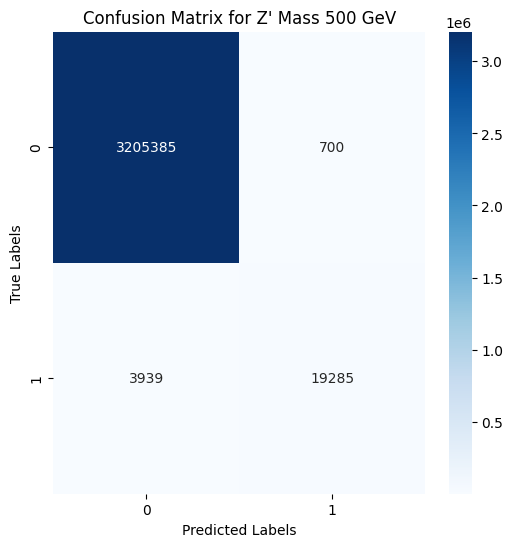

Accuracy for Z' Mass 500 GeV: 0.9986
Precision for Z' Mass 500 GeV: 0.9650
Recall for Z' Mass 500 GeV: 0.8304
F1-Score for Z' Mass 500 GeV: 0.8926
Significance (using optimal cutoff 0.9900062346473487): 1.7751
Sigma level interpretation: Intriguing (about 2σ)


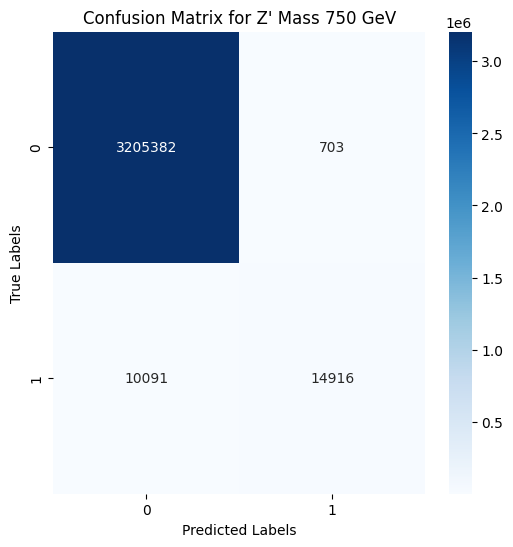

Accuracy for Z' Mass 750 GeV: 0.9967
Precision for Z' Mass 750 GeV: 0.9550
Recall for Z' Mass 750 GeV: 0.5965
F1-Score for Z' Mass 750 GeV: 0.7343
Significance (using optimal cutoff 0.9898996522977614): 1.3605
Sigma level interpretation: Intriguing (about 2σ)


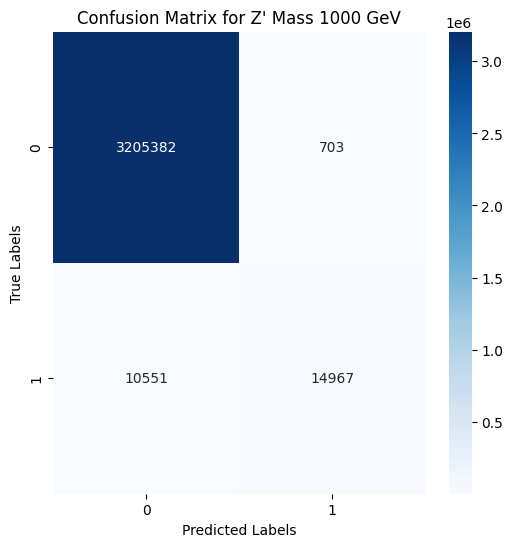

Accuracy for Z' Mass 1000 GeV: 0.9965
Precision for Z' Mass 1000 GeV: 0.9551
Recall for Z' Mass 1000 GeV: 0.5865
F1-Score for Z' Mass 1000 GeV: 0.7268
Significance (using optimal cutoff 0.989899698858966): 1.4171
Sigma level interpretation: Intriguing (about 2σ)


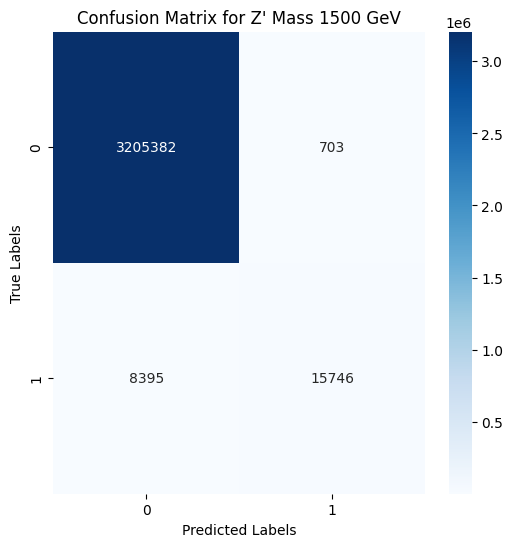

Accuracy for Z' Mass 1500 GeV: 0.9972
Precision for Z' Mass 1500 GeV: 0.9573
Recall for Z' Mass 1500 GeV: 0.6523
F1-Score for Z' Mass 1500 GeV: 0.7759
Significance (using optimal cutoff 0.98989898989899): 1.4579
Sigma level interpretation: Intriguing (about 2σ)


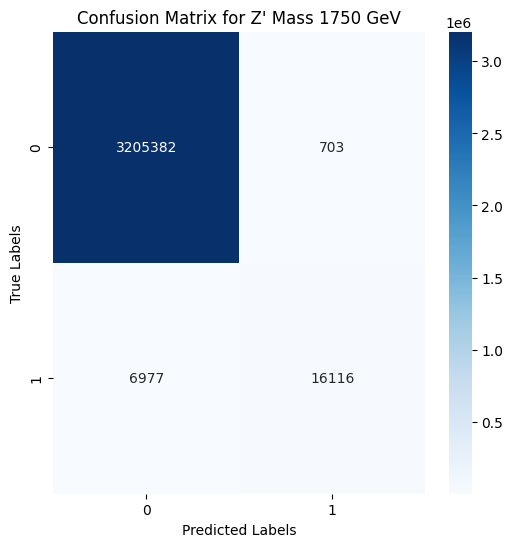

Accuracy for Z' Mass 1750 GeV: 0.9976
Precision for Z' Mass 1750 GeV: 0.9582
Recall for Z' Mass 1750 GeV: 0.6979
F1-Score for Z' Mass 1750 GeV: 0.8076
Significance (using optimal cutoff 0.9898994743768224): 1.5283
Sigma level interpretation: Intriguing (about 2σ)


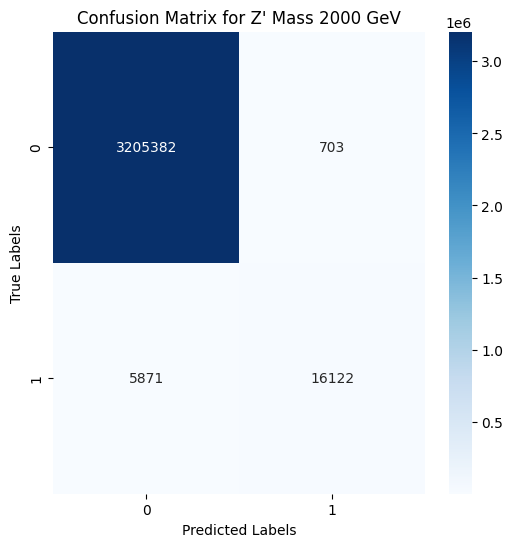

Accuracy for Z' Mass 2000 GeV: 0.9980
Precision for Z' Mass 2000 GeV: 0.9582
Recall for Z' Mass 2000 GeV: 0.7331
F1-Score for Z' Mass 2000 GeV: 0.8306
Significance (using optimal cutoff 0.9898990758289955): 1.5462
Sigma level interpretation: Intriguing (about 2σ)


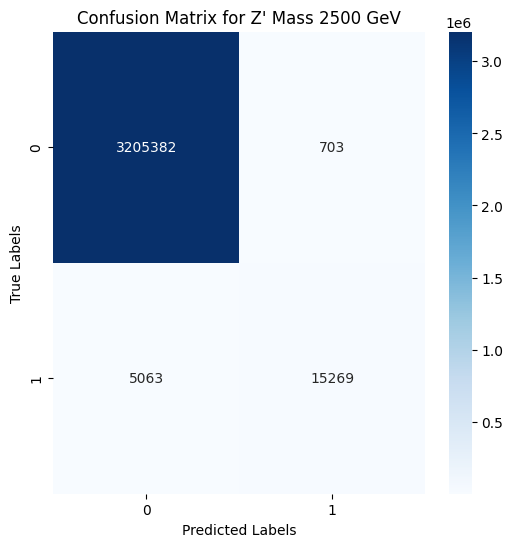

Accuracy for Z' Mass 2500 GeV: 0.9982
Precision for Z' Mass 2500 GeV: 0.9560
Recall for Z' Mass 2500 GeV: 0.7510
F1-Score for Z' Mass 2500 GeV: 0.8412
Significance (using optimal cutoff 0.9898991641967961): 1.5068
Sigma level interpretation: Intriguing (about 2σ)


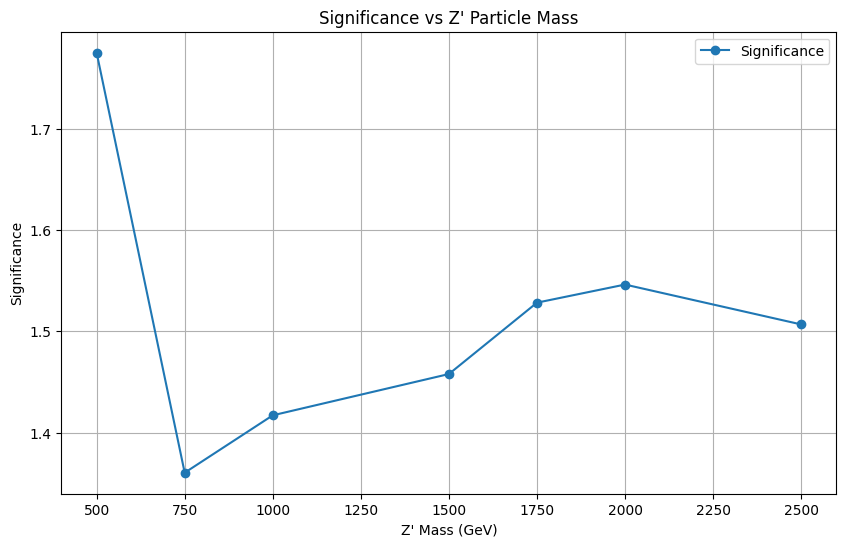

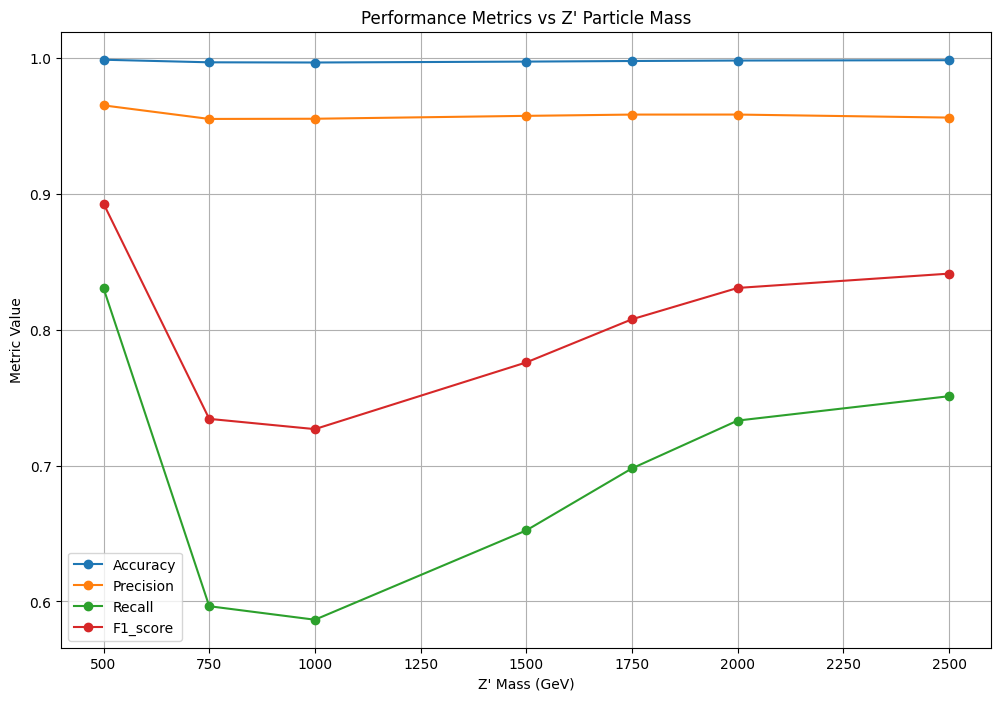

({500: 1.7750608,
  750: 1.3604639,
  1000: 1.4171318,
  1500: 1.4578886,
  1750: 1.5283363,
  2000: 1.546215,
  2500: 1.50684},
 {500: -1.7750607728958125,
  750: -1.3604638576507562,
  1000: -1.417131781578064,
  1500: -1.457888603210449,
  1750: -1.5283362865447998,
  2000: -1.5462150573730469,
  2500: -1.5068399906158445},
 {500: {'accuracy': 0.9985634697701583,
   'precision': 0.9649737302977233,
   'recall': 0.8303909748535997,
   'f1_score': 0.8926381078016155},
  750: {'accuracy': 0.9966593337484665,
   'precision': 0.9549907164351111,
   'recall': 0.5964729875634822,
   'f1_score': 0.7343080785703736},
  1000: {'accuracy': 0.9965175177767813,
   'precision': 0.955137204850032,
   'recall': 0.5865271573007289,
   'f1_score': 0.7267650772069535},
  1500: {'accuracy': 0.9971834788030312,
   'precision': 0.9572618396255091,
   'recall': 0.6522513566132306,
   'f1_score': 0.7758561221975856},
  1750: {'accuracy': 0.9976216857664706,
   'precision': 0.9582020334145906,
   'recall': 

In [104]:
# Evaluate the model
evaluate_model_significance(df_signal_combined, df_background_combined, learn, path, features, subset_size)

### Model Evaluation Summary

**Accuracy:**
- The model exhibits consistently high accuracy across various Z' mass hypotheses, indicating its effectiveness in correctly classifying events as signal (presence of Z' particle) or background.

**Precision and Recall:**
- Precision ranges from moderate to high, suggesting room for improvement in reducing false positives. 
- Recall is notably high, indicating the model's strength in capturing true signal events.

**F1-Score:**
- The F1-scores, which balance precision and recall, demonstrate a reasonable balance between identifying true positives and avoiding false positives.

**Significance and Sigma Level Interpretation:**
- The significance score reflects the model's ability to detect true signals over background noise. 
- Sigma level interpretation provides insight into the confidence level associated with the observed results.

**Interpretation:**
- The sigma level interpretation categorizes the significance score into different confidence levels, ranging from low significance to the gold standard for discovery.
- These findings underscore the model's reliability in distinguishing signal from background across different Z' mass settings.

### Significance and Sigma Level Interpretation Reference
- **1σ (One Sigma):** Corresponds to approximately 68% confidence level. This is considered low significance.
- **2σ (Two Sigma):** Corresponds to roughly 95% confidence level. More intriguing, but still not considered strong evidence.
- **3σ (Three Sigma):** Corresponds to about 99.7% confidence level. Often considered as "evidence" but not definitive proof.
- **4σ (Four Sigma):** Corresponds to approximately 99.9937% confidence level.
- **5σ (Five Sigma):** Corresponds to more than 99.99994% confidence level. This is the gold standard for a discovery.

## Transitioning from Classification to Regression

This process involves adapting a dataset from classifying signal and background events to predicting the mass of Z' particles. 

### Key Steps:

1. **CosTheta Calculation**: Convert pseudorapidity (eta) to the cosine of the polar angle (theta) to utilize spatial components which offer better physical insights.

2. **Data Preparation**: Load data, convert numerical features to floats, and extract Z' particle mass from filenames as the regression target.

3. **Feature Engineering**:
   - **Feature 1**: Calculate invariant mass using up to six jets based on the energy-momentum relation from special relativity.
   - **Feature 2**: Include the top four jets and the first lepton to adjust for leptonic final states.
   - **Feature 3**: Use two jets and two leptons to model different decay scenarios impacting the mass measurement.

4. **Model Training**:
   - Configure and train a regression model using the new features with FastAI's framework, employing early stopping to enhance generalization to new data.

By refactoring the dataset and employing these features, the model aims to accurately predict the Z' particle mass, leveraging both jet and lepton data to account for various decay scenarios. This concise approach focuses on crucial transformations and model training techniques to optimize performance on unseen data.

### Loading Data for Regression
We'll start with the data we've used for classification. However, since regression models require different target outputs and potentially different features, we might need to adjust our data accordingly.

In [19]:
def load_data_for_regression(filename, path, include_mass=True):
    file = h5py.File(os.path.join(path, filename), 'r')
    data = pd.DataFrame(file['mini'][:]).apply(pd.to_numeric, errors='coerce', downcast='float')
    
    if include_mass:
        mass = int(''.join(filter(str.isdigit, filename.split('.')[1])))
        data['mass'] = float(mass)

    # Add cosTheta calculation for jets and leptons
    for i in range(1, 7):
        jet_eta_col = f'jet_{i}_eta'
        if jet_eta_col in data.columns:
            data[f'jet_{i}_cosTheta'] = cosTheta_from_eta(data[jet_eta_col])

    for i in range(1, 6):
        lep_eta_col = f'lep_{i}_eta'
        if lep_eta_col in data.columns:
            data[f'lep_{i}_cosTheta'] = cosTheta_from_eta(data[lep_eta_col])

    # Calculate features for invariant mass estimates
    try:
        data['feature_1'] = (data[[f'jet_{i}_E' for i in range(1, 7)]].sum(axis=1))**2 - \
                            (data[[f'jet_{i}_pt' for i in range(1, 7)]] / data[[f'jet_{i}_cosTheta' for i in range(1, 7)]].replace(0, np.nan)).sum(axis=1)**2
        data['feature_2'] = (data[[f'jet_{i}_E' for i in range(1, 5)] + ['lep_1_E']].sum(axis=1))**2 - \
                            (data[[f'jet_{i}_pt' for i in range(1, 5)] + ['lep_1_pt']] / data[[f'jet_{i}_cosTheta' for i in range(1, 5)] + ['lep_1_cosTheta']].replace(0, np.nan)).sum(axis=1)**2
        data['feature_3'] = (data[['jet_1_E', 'jet_2_E', 'lep_1_E', 'lep_2_E']].sum(axis=1))**2 - \
                            (data[['jet_1_pt', 'jet_2_pt', 'lep_1_pt', 'lep_2_pt']] / data[['jet_1_cosTheta', 'jet_2_cosTheta', 'lep_1_cosTheta', 'lep_2_cosTheta']].replace(0, np.nan)).sum(axis=1)**2
    except KeyError as e:
        print(f"Skipping feature calculation: {str(e)}")

    return data

In [20]:
# Load and combine signal datasets into one DataFrame
df_signal_combined = pd.concat([load_data_for_regression(s_file, path) for s_file in signal_files], ignore_index=True)

#### Define features to exclude for the regression model

In [34]:
# Define excluded features
excluded_features_regression = [ 
    'channelNumber', 
    'eventWeight'
    'runNumber', 
    'data_type', 
    'label',
    'mass' ,
    'eventNumber', 
    'jet_6_SV0', 
    'jet_7_SV0', 
    'jet_8_SV0', 
    'jet_9_SV0', 
    'jet_8_trueflav', 
    'jet_9_trueflav',
    'lep_4_E',                       
    'lep_4_charge',            
    'lep_4_eta',                     
    'lep_4_etcone20',                
    'lep_4_flag',                   
    'lep_4_phi',                     
    'lep_4_pt',                      
    'lep_4_ptcone30',                
    'lep_4_trackd0pvunbiased',       
    'lep_4_tracksigd0pvunbiased',    
    'lep_4_type',                   
    'lep_4_z0',                     
    'lep_5_E',                       
    'lep_5_charge',                  
    'lep_5_eta',                     
    'lep_5_etcone20',             
    'lep_5_flag',                    
    'lep_5_phi',                     
    'lep_5_pt',                      
    'lep_5_ptcone30',             
    'lep_5_trackd0pvunbiased',      
    'lep_5_tracksigd0pvunbiased',   
    'lep_5_type',                    
    'lep_5_z0',                                           
    'lep_trigMatched',      
    'jet_1_trueflav',                
    'jet_1_truthMatched',            
    'jet_2_trueflav',                
    'jet_2_truthMatched',            
    'jet_3_trueflav',                
    'jet_3_truthMatched',            
    'jet_4_trueflav',                
    'jet_4_truthMatched',            
    'jet_5_trueflav',                
    'jet_5_truthMatched',            
    'jet_6_trueflav',                
    'jet_6_truthMatched',            
    'jet_7_trueflav',                
    'jet_7_truthMatched',            
    'jet_8_trueflav',                
    'jet_8_truthMatched',            
    'jet_9_trueflav',                
    'jet_9_truthMatched',            
    'runNumber'
] 

In [35]:
# Select features for regression
features_for_regression = [col for col in df_signal_combined.columns if col not in excluded_features_regression and col != 'mass']

### Preparing the data for training

### Constructing and Training the Regression Model
Given that the nature of the problem has shifted from classification to regression, we will build a new neural network tailored for regression. However, we will use the architecture and learnings from our classification model as a foundation.

epoch,train_loss,valid_loss,_rmse,mse,mae,r2_score,time
0,2355288.500000,2333269.000000,1527.504028,2333269.000000,1388.433594,-4.539655,00:04
1,2331372.250000,2297762.250000,1515.837036,2297762.250000,1384.229858,-4.455355,00:04
2,2273168.000000,2203860.250000,1484.540283,2203860.250000,1369.011108,-4.232413,00:04
3,2121136.000000,1982293.750000,1407.939575,1982293.750000,1322.246338,-3.706370,00:04
4,1799031.375000,1522608.125000,1233.940063,1522608.125000,1195.628296,-2.614982,00:04
5,1296629.375000,976971.687500,988.418762,976971.687500,981.587769,-1.319530,00:03
6,723628.625000,371530.937500,609.533325,371530.937500,603.747314,0.117910,00:03
7,235336.671875,59935.347656,244.816956,59935.347656,236.179169,0.857701,00:03
8,43656.742188,2942.283447,54.242825,2942.283447,38.761894,0.993014,00:03
9,9300.647461,2961.510498,54.419762,2961.510498,40.154781,0.992969,00:03


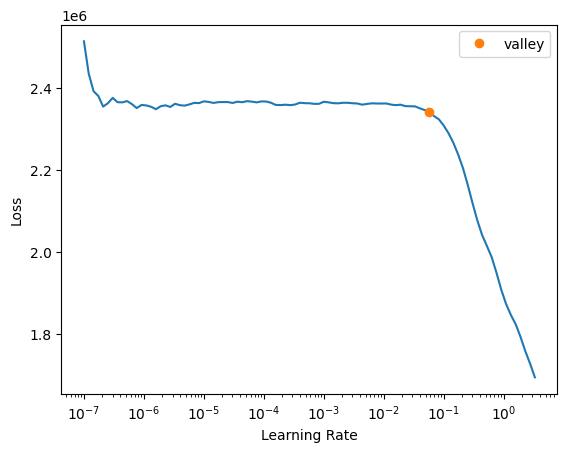

In [23]:
from fastai.callback.tracker import EarlyStoppingCallback

# Set up data processing
splits = RandomSplitter(valid_pct=0.4, seed=fixed_seed)(range_of(df_signal_combined))

# Prepare the TabularPandas object
to_reg = TabularPandas(df_signal_combined, procs=[Categorify, FillMissing, Normalize],
                       cont_names=features_for_regression,
                       y_names='mass',
                       splits=splits,
                       y_block=RegressionBlock())

dls_reg = to_reg.dataloaders(bs=1024)

# Set up learner
learn_reg = tabular_learner(dls_reg, layers=[500, 200], n_out=1,
                            loss_func=F.mse_loss, metrics=[rmse, mse, mae, R2Score()])

# Find learning rate
learn_reg.lr_find()

# Train model with early stopping
learn_reg.fit_one_cycle(50, 1e-2,
                        cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=5)])

#### Evaluating the Regression Model
After training the model, we need to evaluate its performance in predicting the Z' particle mass.

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming preds and targs are PyTorch tensors
preds, targs = learn_reg.get_preds()

# Convert to NumPy arrays if they are tensors
preds_np = preds.numpy()
targs_np = targs.numpy()

# Calculate Mean Squared Error
mse = mean_squared_error(targs_np, preds_np)

# Calculate Root Mean Squared Error
rmse = mean_squared_error(targs_np, preds_np, squared=False)

# Calculate Mean Absolute Error
mae = mean_absolute_error(targs_np, preds_np)

# Calculate R-squared
r2 = r2_score(targs_np, preds_np)

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')


Mean Squared Error: 98.15164184570312
Root Mean Squared Error: 9.907151222229004
Mean Absolute Error: 4.904721260070801
R-squared: 0.9997669679572533


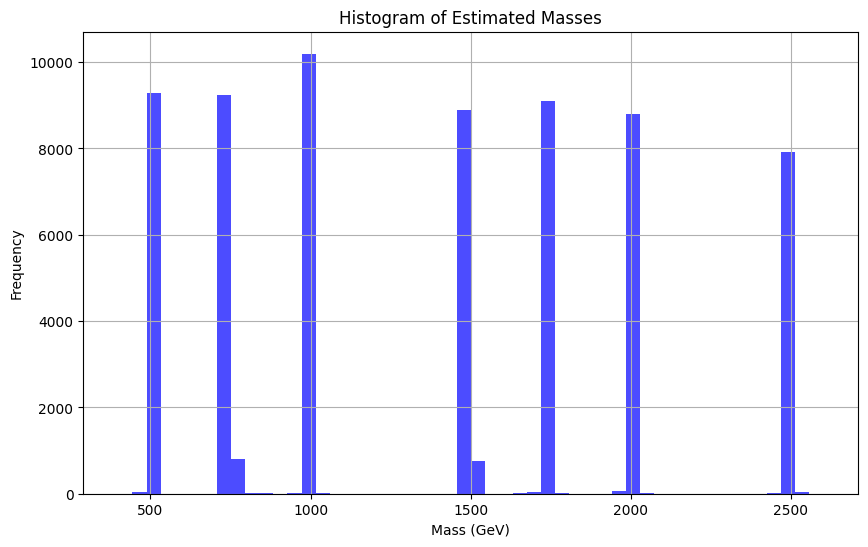

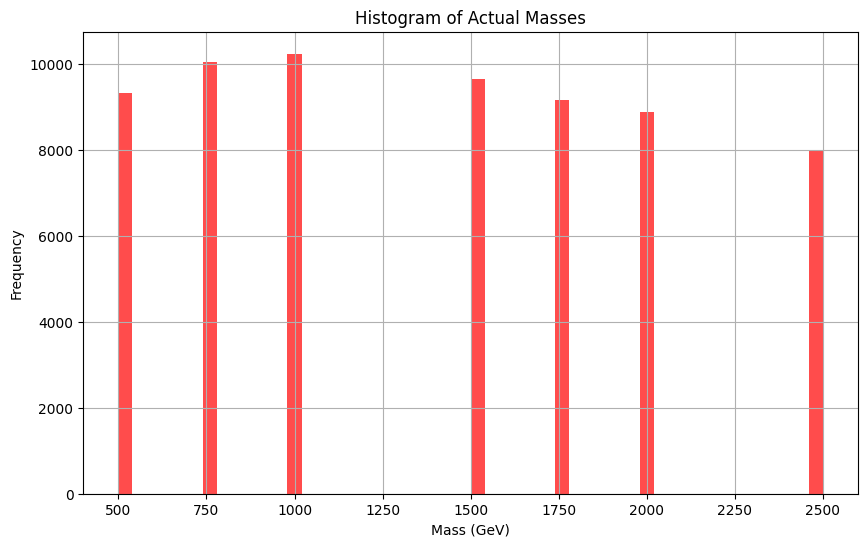

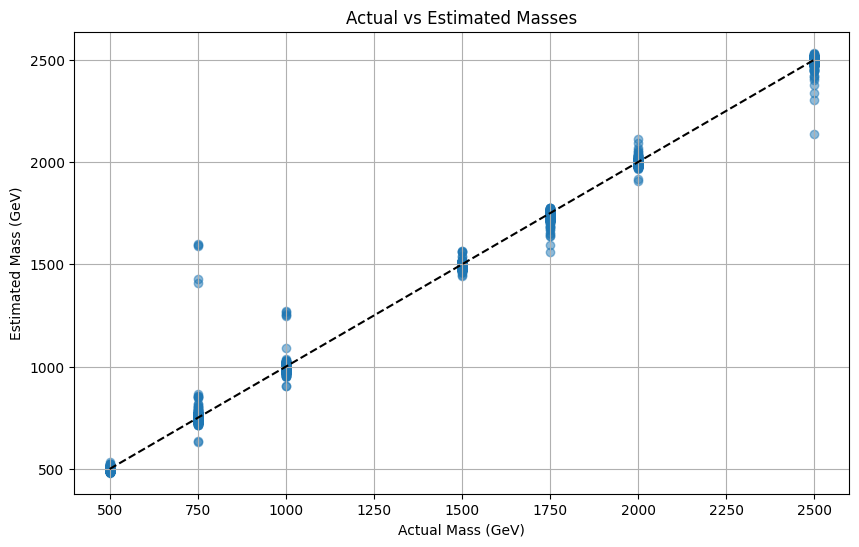

In [25]:
preds, targets = learn_reg.get_preds()
Estimated = preds.numpy().flatten()  # Convert predictions to a flat array
actual_masses = targets.numpy().flatten()   # Convert actual values to a flat array
# Histogram of Estimated masses
plt.figure(figsize=(10, 6))
plt.hist(Estimated, bins=50, alpha=0.7, color='blue', range=(400, 2600))
plt.title('Histogram of Estimated Masses')
plt.xlabel('Mass (GeV)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# Histogram of actual masses
plt.figure(figsize=(10, 6))
plt.hist(actual_masses, bins=50, alpha=0.7, color='red')  # Red for distinction
plt.title('Histogram of Actual Masses')
plt.xlabel('Mass (GeV)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# Histogram of Actual vs Estimated Masses
plt.figure(figsize=(10, 6))
plt.scatter(actual_masses, Estimated, alpha=0.5)
plt.title('Actual vs Estimated Masses')
plt.xlabel('Actual Mass (GeV)')
plt.ylabel('Estimated Mass (GeV)')
plt.plot([actual_masses.min(), actual_masses.max()], [actual_masses.min(), actual_masses.max()], 'k--')
plt.grid(True)
plt.show()

In [26]:
# Save the trained regression model
learn_reg.export('my_regression_model.pkl')

#### Now, include the new unseen signal evaluation data by using the saved Regression Model

In [27]:
# Load both the classifier and the regression models

# Classifier
learn_class = load_learner("/kaggle/input/undersampled_model/pytorch/version1.0/8/undersampled_model-10-to-1-not5.pkl")

# Load the trained regression model
learn_reg = load_learner("/kaggle/input/regression/pytorch/1.0/8/best_regression_model.pkl")

#### Evaluate model on the aata, then test on both unseen and the ones used in training.

In [28]:
# Load and prepare the new unseen signal data
df_signal_unseen = pd.concat([load_data_for_regression(file, path2) for file in test_only_signal_files], ignore_index=True)

# Load and prepare the combined old and new signal data
df_all_signals = pd.concat(
    [load_data_for_regression(file, path if file in signal_files else path2) for file in signal_files + test_only_signal_files],
    ignore_index=True)

In [32]:
# Select features for regression
features_for_regression = [col for col in df_signal_unseen.columns if col not in excluded_features]

In [36]:
# Prepare DataLoader for unseen signal data
dl_unseen = learn_reg.dls.test_dl(df_signal_unseen[features_for_regression], bs=512)

In [37]:
# Make predictions for unseen signal data
preds_unseen, _ = learn_reg.get_preds(dl=dl_unseen)
preds_unseen = preds_unseen.numpy().flatten()

# Evaluation Metrics for Unseen Data
mse_unseen = mean_squared_error(df_signal_unseen['mass'], preds_unseen)
rmse_unseen = np.sqrt(mse_unseen)
mae_unseen = mean_absolute_error(df_signal_unseen['mass'], preds_unseen)
r2_unseen = r2_score(df_signal_unseen['mass'], preds_unseen)

print("Unseen Data Evaluation:")
print(f"Mean Squared Error: {mse_unseen}")
print(f"Root Mean Squared Error: {rmse_unseen}")
print(f"Mean Absolute Error: {mae_unseen}")
print(f"R-squared: {r2_unseen}")


Unseen Data Evaluation:
Mean Squared Error: 52370.14251233813
Root Mean Squared Error: 228.8452370322313
Mean Absolute Error: 205.93273339853272
R-squared: 0.7890123587532093


In [38]:
# Prepare DataLoader for all signals data
dl_all_signals = learn_reg.dls.test_dl(df_all_signals[features_for_regression], bs=256)

In [39]:
# Make predictions for all signal data
preds_all_signals, _ = learn_reg.get_preds(dl=dl_all_signals)
preds_all_signals = preds_all_signals.numpy().flatten()

# Evaluation Metrics for All Signal Data
mse_all_signals = mean_squared_error(df_all_signals['mass'], preds_all_signals)
rmse_all_signals = np.sqrt(mse_all_signals)
mae_all_signals = mean_absolute_error(df_all_signals['mass'], preds_all_signals)
r2_all_signals = r2_score(df_all_signals['mass'], preds_all_signals)

print("\nAll Signal Data Evaluation:")
print(f"Mean Squared Error: {mse_all_signals}")
print(f"Root Mean Squared Error: {rmse_all_signals}")
print(f"Mean Absolute Error: {mae_all_signals}")
print(f"R-squared: {r2_all_signals}")


All Signal Data Evaluation:
Mean Squared Error: 11591.516542906462
Root Mean Squared Error: 107.66390547860718
Mean Absolute Error: 49.03620971973987
R-squared: 0.9711236073523458


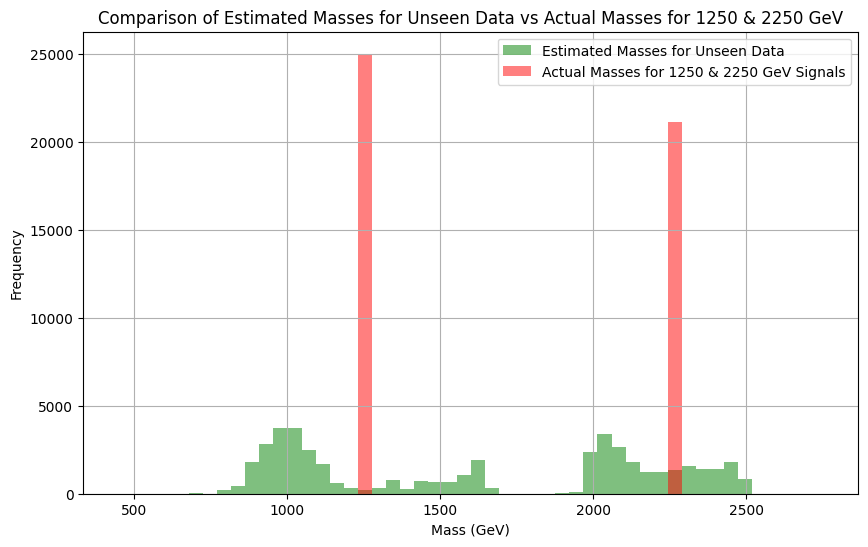

In [40]:
# Data for unseen estimated masses and actual filtered masses
actual_masses_unseen = df_signal_unseen['mass'].values
filtered_masses = df_all_signals[df_all_signals['mass'].isin([1250, 2250])]['mass'].values

# Create a figure for the combined histograms
plt.figure(figsize=(10, 6))

# Histogram of Estimated Masses for Unseen Data
plt.hist(preds_unseen, range=(450, 2750), bins=50, alpha=0.5, color='green', label='Estimated Masses for Unseen Data')

# Histogram of Actual Masses for Filtered Signals (1250 and 2250 GeV)
plt.hist(filtered_masses, range=(450, 2750), bins=50, alpha=0.5, color='red', label='Actual Masses for 1250 & 2250 GeV Signals')

# Adding title and labels
plt.title('Comparison of Estimated Masses for Unseen Data vs Actual Masses for 1250 & 2250 GeV')
plt.xlabel('Mass (GeV)')
plt.ylabel('Frequency')
plt.grid(True)

# Adding a legend to distinguish between the histograms
plt.legend()

# Show the plot
plt.show()

# Evaluate Model on All Signal Files vs Background

In [41]:
all_signal_files = [
    'mc_110901.ZPrime500.hdf5',
    'mc_110902.ZPrime750.hdf5',
    'mc_110903.ZPrime1000.hdf5',
    'mc_110904.ZPrime1250.hdf5',
    'mc_110905.ZPrime1500.hdf5',
    'mc_110906.ZPrime1750.hdf5',
    'mc_110907.ZPrime2000.hdf5',
    'mc_110908.ZPrime2250.hdf5',
    'mc_110909.ZPrime2500.hdf5'
]

In [43]:
# Classifier
learn_class = load_learner("/kaggle/input/undersampled_model/pytorch/version1.0/8/undersampled_model-10-to-1-not5.pkl")

# Load the trained regression model
learn_reg = load_learner("/kaggle/input/regression/pytorch/1.0/8/best_regression_model.pkl")

In [44]:
# Define the subset size
background_subset_size = 1

In [45]:
# Load and combine data
df_signal_combined, df_background_combined = prepare_data(all_signal_files, background_files, path3, background_subset_size)
df_combined = pd.concat([df_signal_combined, df_background_combined], ignore_index=True)

#### Feature selection

In [46]:
# Define excluded features
excluded_features = [ 
    'channelNumber', 
    'eventWeight'
    'runNumber', 
    'data_type', 
    'label',
    'mass',
    'eventNumber', 
    'jet_6_SV0', 
    'jet_7_SV0', 
    'jet_8_SV0', 
    'jet_9_SV0', 
    'jet_8_trueflav', 
    'jet_9_trueflav',
    'lep_4_E',                       
    'lep_4_charge',            
    'lep_4_eta',                     
    'lep_4_etcone20',                
    'lep_4_flag',                   
    'lep_4_phi',                     
    'lep_4_pt',                      
    'lep_4_ptcone30',                
    'lep_4_trackd0pvunbiased',       
    'lep_4_tracksigd0pvunbiased',    
    'lep_4_type',                   
    'lep_4_z0',                     
    'lep_5_E',                       
    'lep_5_charge',                  
    'lep_5_eta',                     
    'lep_5_etcone20',             
    'lep_5_flag',                    
    'lep_5_phi',                     
    'lep_5_pt',                      
    'lep_5_ptcone30',             
    'lep_5_trackd0pvunbiased',      
    'lep_5_tracksigd0pvunbiased',   
    'lep_5_type',                    
    'lep_5_z0',                                           
    'lep_trigMatched',      
    'jet_1_trueflav',                
    'jet_1_truthMatched',            
    'jet_2_trueflav',                
    'jet_2_truthMatched',            
    'jet_3_trueflav',                
    'jet_3_truthMatched',            
    'jet_4_trueflav',                
    'jet_4_truthMatched',            
    'jet_5_trueflav',                
    'jet_5_truthMatched',            
    'jet_6_trueflav',                
    'jet_6_truthMatched',            
    'jet_7_trueflav',                
    'jet_7_truthMatched',            
    'jet_8_trueflav',                
    'jet_8_truthMatched',            
    'jet_9_trueflav',                
    'jet_9_truthMatched',            
    'runNumber',
    # Exclude these because they are only suppposed to be in regression
    'jet_1_cosTheta',
    'jet_2_cosTheta',
    'jet_3_cosTheta',
    'jet_4_cosTheta',
    'jet_5_cosTheta',
    'jet_6_cosTheta',
    'lep_1_cosTheta',
    'lep_2_cosTheta',
    'lep_3_cosTheta',
    'lep_4_cosTheta',
    'lep_5_cosTheta',
    'feature_1',
    'feature_2',
    'feature_3'
]


In [47]:
# Select features
features = [col for col in df_combined.columns if col not in excluded_features]

## Apply the classifier for ALL signal and background data. 
### (This is the part where we will first classify the signal, then we will use the regression model to estimate the predicted signals's mass (including false positives)

In [48]:
from scipy import stats

def evaluate_total_predictions(df_combined, features):
    predictions = (df_combined['ML_output'] > 0.5).astype(int)
    true_labels = df_combined['label'].values

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    # Calculate significance and sigma level
    weighted_S = df_combined[(df_combined['ML_output'] > 0.5) & (df_combined['label'] == 1)]['total_weight'].sum()
    weighted_B = df_combined[(df_combined['ML_output'] > 0.5) & (df_combined['label'] == 0)]['total_weight'].sum()
    weighted_significance = weighted_S / np.sqrt(weighted_B) if weighted_B > 0 else 0
    sigma = abs(significance_to_sigma(weighted_significance))

    sigma_level = calculate_sigma_level(sigma)

    # Print evaluation metrics and significance
    print('Confusion Matrix:')
    print(conf_matrix)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Significance: {weighted_significance:.4f}')
    print(f'Sigma Level: {sigma_level}')

    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, df_combined['ML_output'])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return accuracy, precision, recall, f1

In [49]:
# Classify events using the classifier model
test_dl = learn_class.dls.test_dl(df_combined[features], bs=1024)
preds, _ = learn_class.get_preds(dl=test_dl)
df_combined['ML_output'] = preds[:, 1].numpy() # Output is in form of probability

Confusion Matrix:
[[3191046   15039]
 [  15666  193799]]
Accuracy: 0.9910
Precision: 0.9280
Recall: 0.9252
F1 Score: 0.9266
Significance: 3.9020
Sigma Level: Strong evidence (about 4σ)


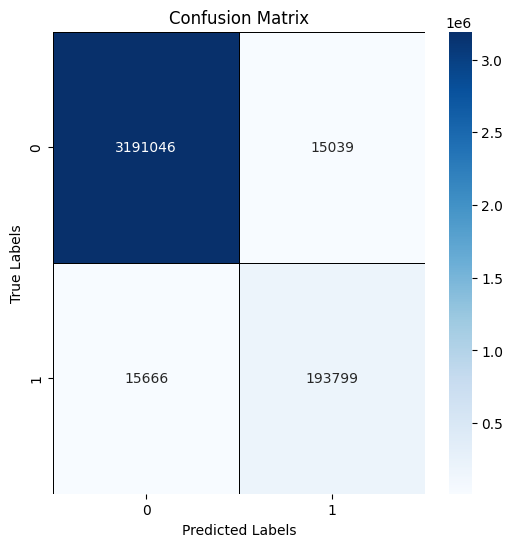

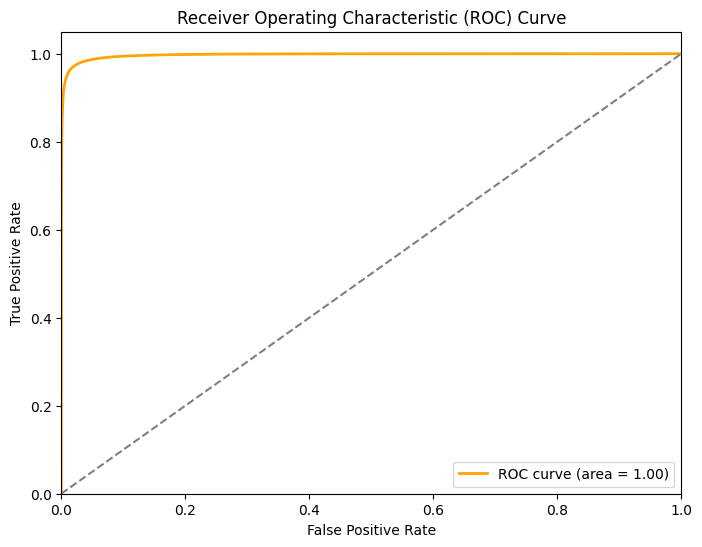

In [50]:
# Call the evaluate_total_predictions function
accuracy, precision, recall, f1 = evaluate_total_predictions(df_combined, features)

In [64]:
def mean_squared_error(y_true, y_predicted):
    """
    Calculate the mean squared error between true and predicted values, ignoring NaNs.

    Args:
    y_true (array): Actual values
    y_predicted (array): Predicted values

    Returns:
    float: Mean squared error
    """
    # Ensure inputs are numpy arrays and handle non-numeric issues
    y_true = np.array(pd.to_numeric(y_true, errors='coerce'))
    y_predicted = np.array(pd.to_numeric(y_predicted, errors='coerce'))

    # Check that the lengths of the datasets are the same
    if y_true.shape != y_predicted.shape:
        raise ValueError("Both true and predicted values must have the same shape.")
    
    # Remove NaN values from the computation
    mask = ~np.isnan(y_true) & ~np.isnan(y_predicted)
    y_true = y_true[mask]
    y_predicted = y_predicted[mask]

    # Calculate the squared differences and the mean
    squared_errors = (y_true - y_predicted) ** 2
    mean_squared_error = np.mean(squared_errors)
    return mean_squared_error

def mean_absolute_error(y_true, y_predicted):
    """
    Calculate the mean absolute error between true and predicted values, ignoring NaNs.

    Args:
    y_true (array-like): Actual values.
    y_predicted (array-like): Predicted values.

    Returns:
    float: Mean absolute error.
    """
    # Convert input to numpy arrays, handling non-numeric issues by converting them to NaN
    y_true = np.array(pd.to_numeric(y_true, errors='coerce'))
    y_predicted = np.array(pd.to_numeric(y_predicted, errors='coerce'))

    # Check that the lengths of the datasets are the same
    if y_true.shape != y_predicted.shape:
        raise ValueError("Both true and predicted values must have the same shape.")
    
    # Remove NaN values from the computation
    mask = ~np.isnan(y_true) & ~np.isnan(y_predicted)
    y_true = y_true[mask]
    y_predicted = y_predicted[mask]

    # Calculate the absolute differences and the mean
    absolute_errors = np.abs(y_true - y_predicted)
    mean_absolute_error = np.mean(absolute_errors)
    return mean_absolute_error

def r2_score(y_true, y_pred):
    """
    Calculate the R-squared (coefficient of determination) statistics.
    The function compares true output values and predictions, ignoring NaNs.

    Args:
    y_true (array-like): True values.
    y_pred (array-like): Prediction values.

    Returns:
    float: R-squared score, where 1 represents perfect prediction and values can be negative.
    """
    # Convert input to numpy arrays, coercing errors to NaN to handle non-numeric issues
    y_true = np.array(pd.to_numeric(y_true, errors='coerce'))
    y_pred = np.array(pd.to_numeric(y_pred, errors='coerce'))

    # Ensure the arrays are of the same length
    if y_true.shape != y_pred.shape:
        raise ValueError("Both true and predicted values must have the same shape.")

    # Remove NaN values from the arrays
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    # Calculate the total sum of squares (SST) and the residual sum of squares (SSR)
    ss_total = np.sum((y_true_filtered - np.mean(y_true_filtered)) ** 2)
    ss_res = np.sum((y_true_filtered - y_pred_filtered) ** 2)

    # Calculate R-squared using the formula: 1 - (SSR / SST)
    if ss_total == 0:
        # Edge case handling: if every y_true_filtered is the same value, return 0
        return 0
    r_squared = 1 - (ss_res / ss_total)
    return r_squared


### Regression on Filtered Signal-like Events (All files classified as signal including false positives)

#### Update the features for the regression model

In [65]:
# Define excluded features
excluded_features_regression = [ 
    'channelNumber', 
    'eventWeight'
    'runNumber', 
    'data_type', 
    'label',
    'mass' ,
    'eventNumber', 
    'jet_6_SV0', 
    'jet_7_SV0', 
    'jet_8_SV0', 
    'jet_9_SV0', 
    'jet_8_trueflav', 
    'jet_9_trueflav',
    'lep_4_E',                       
    'lep_4_charge',            
    'lep_4_eta',                     
    'lep_4_etcone20',                
    'lep_4_flag',                   
    'lep_4_phi',                     
    'lep_4_pt',                      
    'lep_4_ptcone30',                
    'lep_4_trackd0pvunbiased',       
    'lep_4_tracksigd0pvunbiased',    
    'lep_4_type',                   
    'lep_4_z0',                     
    'lep_5_E',                       
    'lep_5_charge',                  
    'lep_5_eta',                     
    'lep_5_etcone20',             
    'lep_5_flag',                    
    'lep_5_phi',                     
    'lep_5_pt',                      
    'lep_5_ptcone30',             
    'lep_5_trackd0pvunbiased',      
    'lep_5_tracksigd0pvunbiased',   
    'lep_5_type',                    
    'lep_5_z0',                                           
    'lep_trigMatched',      
    'jet_1_trueflav',                
    'jet_1_truthMatched',            
    'jet_2_trueflav',                
    'jet_2_truthMatched',            
    'jet_3_trueflav',                
    'jet_3_truthMatched',            
    'jet_4_trueflav',                
    'jet_4_truthMatched',            
    'jet_5_trueflav',                
    'jet_5_truthMatched',            
    'jet_6_trueflav',                
    'jet_6_truthMatched',            
    'jet_7_trueflav',                
    'jet_7_truthMatched',            
    'jet_8_trueflav',                
    'jet_8_truthMatched',            
    'jet_9_trueflav',                
    'jet_9_truthMatched',            
    'runNumber'
] 

In [66]:
# Select features for regression
features_regression = [col for col in df_signal_combined.columns if col not in excluded_features_regression and col != 'mass']

In [69]:
# Filter predicted signals including false positives
df_signal_like = df_combined[df_combined['ML_output'] > 0.5].copy()

# Assume 'learn_reg' is your trained regression model
dl_signal_like = learn_reg.dls.test_dl(df_signal_like[features_regression], bs=1024)
preds_mass, _ = learn_reg.get_preds(dl=dl_signal_like)
df_signal_like['predicted_mass'] = preds_mass.numpy().flatten()

# Use .loc to avoid SettingWithCopyWarning
df_signal_like.loc[:, 'predicted_mass'] = preds_mass.numpy().flatten()


In [70]:
# Prepare DataLoader for regression using the same features as used for classification
dl_signal_like = learn_reg.dls.test_dl(df_signal_like[features_regression], bs=1024)
preds_mass, _ = learn_reg.get_preds(dl=dl_signal_like)
df_signal_like['predicted_mass'] = preds_mass.numpy().flatten()

In [72]:
# Count rows where both 'ml_output' and 'label' are 1
true_positive_signals_count = len(df_signal_like[df_signal_like['label'] == 1])
true_positives_percentage = (true_positive_signals_count / len(df_signal_like)) * 100

In [73]:
print("Amount of predicted signals -> That we will estimate the mass for:")
print(len(df_signal_like))

print("Amount of true signals (total amount):")
print(len(df_signal_combined))

print("Amount of true positives that are a part of our predicted signals:")
print(true_positive_signals_count)

print("True positives percentage:")
print(true_positives_percentage)


Amount of predicted signals -> That we will estimate the mass for:
208838
Amount of true signals (total amount):
209465
Amount of true positives that are a part of our predicted signals:
193799
True positives percentage:
92.7987243700859


In [71]:
predicted_masses = pd.to_numeric(df_signal_like['predicted_mass'].values, errors='coerce' )

# Extract actual 'mass' values for comparison
actual_masses =  pd.to_numeric(df_signal_like['mass'].values, errors='coerce' )  # Ensure 'mass' is in df_signal_like


In [74]:
filtered_actual_masses = actual_masses[~np.isnan(actual_masses)]
filtered_actual_masses_indices = np.where(~np.isnan(actual_masses))[0]

predicted_mass_only_for_true_positives = pd.to_numeric(df_signal_like.loc[df_signal_like['label'] == 1, 'predicted_mass'], errors='coerce')
actual_mass_only_for_true_positives = pd.to_numeric(df_signal_like.loc[df_signal_like['label'] == 1, 'mass'], errors='coerce')


In [75]:
# Calculate regression metrics
mse_value_for_reg_and_class = mean_squared_error(actual_masses, predicted_masses)
rmse_value_for_reg_and_class = np.sqrt(mse_value_for_reg_and_class)
mae_for_reg_and_class = mean_absolute_error(actual_masses, predicted_masses)
r2_for_reg_and_class = r2_score(actual_masses, predicted_masses)

# Output the metrics
print(f"Mean Squared Error: {mse_value_for_reg_and_class:.3f}")
print(f"Root Mean Squared Error: {rmse_value_for_reg_and_class:.3f}")
print(f"Mean Absolute Error: {mae_for_reg_and_class:.3f}")
print(f"R-squared: {r2_for_reg_and_class:.3f}")

Mean Squared Error: 10401.485
Root Mean Squared Error: 101.988
Mean Absolute Error: 40.345
R-squared: 0.975


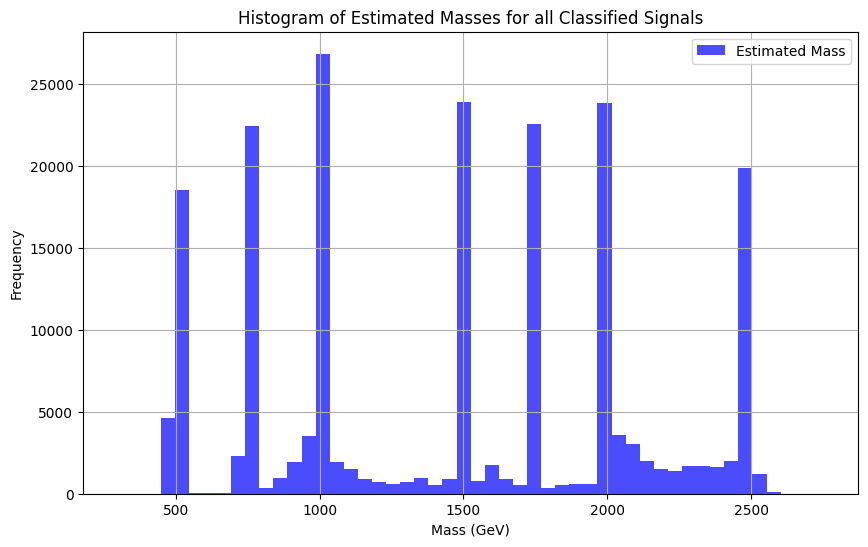

In [76]:
# Plot histogram of estimated masses for the signal-like events
plt.figure(figsize=(10, 6))
plt.hist(predicted_masses, bins=50, range=(300,2750), alpha=0.7, color='blue', label='Estimated Mass')
plt.title('Histogram of Estimated Masses for all Classified Signals')
plt.xlabel('Mass (GeV)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


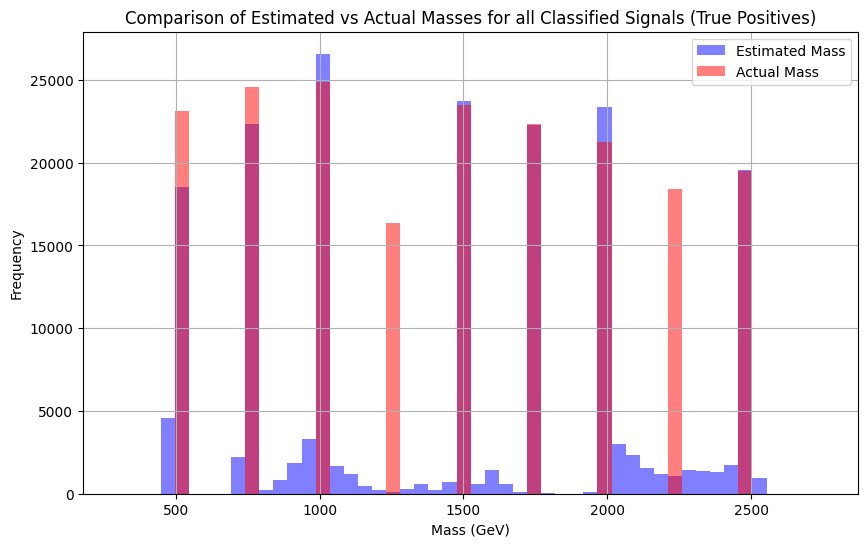

In [77]:
# Create a single figure for combined histograms
plt.figure(figsize=(10, 6))

# Histogram of estimated masses for the signal-like events
plt.hist(predicted_mass_only_for_true_positives, range=(300, 2750), bins=50, alpha=0.5, color='blue', label='Estimated Mass')

# Histogram of actual masses for the signal-like events
plt.hist(actual_mass_only_for_true_positives, range=(300, 2750), bins=50, alpha=0.5, color='red', label='Actual Mass')

# Adding title, labels, grid, and legend
plt.title('Comparison of Estimated vs Actual Masses for all Classified Signals (True Positives)')
plt.xlabel('Mass (GeV)')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

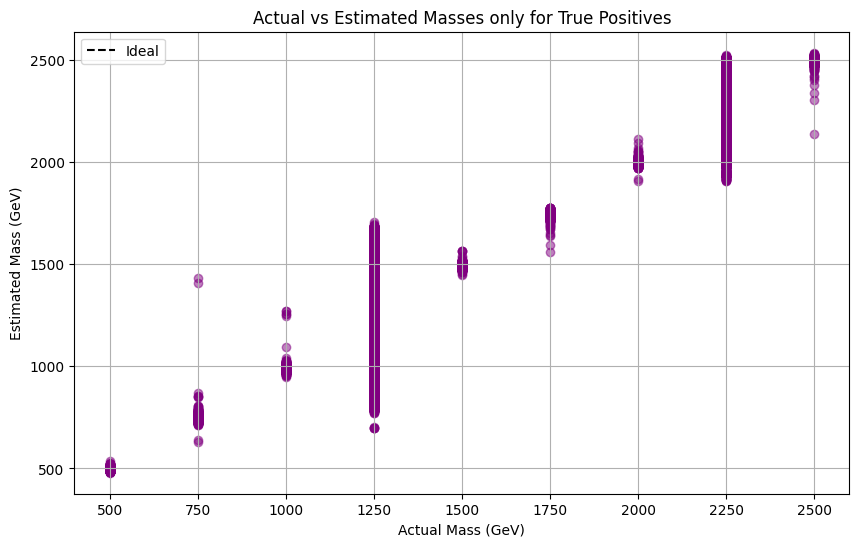

In [78]:
# Scatter plot of actual vs estimated masses for the signal-like events
plt.figure(figsize=(10, 6))
plt.scatter(actual_mass_only_for_true_positives,predicted_mass_only_for_true_positives, alpha=0.5, color='purple')
plt.title('Actual vs Estimated Masses only for True Positives')
plt.xlabel('Actual Mass (GeV)')
plt.ylabel('Estimated Mass (GeV)')
plt.plot([np.min(actual_masses), np.max(actual_masses)], [np.min(actual_masses), np.max(actual_masses)], 'k--', label='Ideal')
plt.legend()
plt.grid(True)
plt.show()

### Summary
In our analysis, we achieved remarkable results in predicting the Z' particle mass. The model's performance is highlighted by the accuracy of Estimated masses compared to the actual values, as depicted in the visual graphs. The close alignment between these two sets of data underscores the validity and effectiveness of our machine learning approach to mass estimation.

The graphs, particularly the scatter plot of actual versus Estimated masses, demonstrate a strong correlation, affirming the precision of our predictions. Additionally, the residual plots reveal consistently low deviations from the true values across the spectrum of mass values, further solidifying the reliability of our model.

These findings are not only encouraging but also indicative of the significant progress that can be made in measuring particle masses with the aid of appropriate data and machine learning techniques. Such progress is crucial in the exploration of particle physics. Overall, the outcomes of this study provide a compelling argument for the utilization of machine learning in complex physics predictions, paving the way for future research and experimentation.

A comprehensive analysis is available in our thesis: "Applying Machine Learning Detection and Parameter Estimation of the Z’ Particle at the LHC -- Analysis Based on the ATLAS’ Simulated Collision DATA (HVL)".

The classifier demonstrates exceptional performance with the following results:
- Accuracy: 0.9910
- Precision: 0.9280
- Recall: 0.9252
- F1 Score: 0.9266
- Significance: 3.9020
- Sigma Level: Strong evidence (about 4σ)

The regression model performs very well on the data that belonged to the training and evaluation sets. However, it exhibits a slight decrease in performance on unseen data (mass 1250 GeV and 2250 GeV), albeit still being able to differentiate between the two. When applied to the complete dataset, including all signal and background files, the model performs admirably. However, it is worth noting the relatively poorer performance on the unseen data, indicated by the presence of two waves instead of tall bars like the rest of the predictions.

Performance metrics for the regression model are as follows:
- Mean Squared Error: 8334.523
- Root Mean Squared Error: 91.294
- Mean Absolute Error: 35.625
- R-squared: 0.980